In [1]:
import numpy as np
import optuna
import pickle
from multiprocessing import Pool
import time
import os
from optuna.distributions import FloatDistribution, LogUniformDistribution
from tqdm.notebook import tqdm
from optuna.samplers import CmaEsSampler

from LIF_sim import run_simulation, worker_function_for_optuna

# =============================================================================
# --- SETTINGS ---
# =============================================================================
N_TOTAL_TRIALS = 2000
N_PARALLEL_JOBS = os.cpu_count() - 2
CV_TARGET_SCORE = -1
N_BEST_TO_KEEP = 500
N_FINAL_SAMPLES = 30000
NOISE_LEVEL = 0.1
OUTPUT_FILENAME = "LIF_training_data_intelligent.pkl"

# =============================================================================
# --- HELPER FUNCTION FOR DATA EXPANSION ---
# =============================================================================
def add_noise_to_params(base_params, noise_level):
    """Adds relative Gaussian noise to a parameter set."""
    noise = np.random.normal(loc=0.0, scale=np.abs(base_params) * noise_level)
    return base_params + noise

# =============================================================================
# --- MAIN EXECUTION BLOCK ---
# =============================================================================
if __name__ == "__main__":
    # Warm-up run to pre-compile Numba functions
    dummy_params = np.array([0.02, 0.04, 0.02, 0.02, 0.03, 0.01, 0.02, 0.03, 0.001,
                             1.0, 4.0, 0.5, 0.5, 0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 
                             0.5, 0.5, 0.04, 0.01, 0.08, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
    run_simulation(dummy_params)

    # --- NEW: Define the search space for the optimizer ---
    search_space = {
        "S_EE": FloatDistribution(0.018, 0.024),
        "S_EPV": FloatDistribution(0.035, 0.055),
        "S_ESOM": FloatDistribution(0.01, 0.035),
        "S_PVE": FloatDistribution(0.010, 0.028),
        "S_PVPV": FloatDistribution(0.022, 0.036),
        "S_PVSOM": FloatDistribution(0.005, 0.015),
        "S_SOME": FloatDistribution(0.008, 0.028),
        "S_SOMPV": FloatDistribution(0.015, 0.045),
        "S_SOMSOM": FloatDistribution(0.0005, 0.003),
        "lam_E": FloatDistribution(0.2, 3.0, log = True),
        "lam_PV": FloatDistribution(0.5, 9.0, log = True),
        "lam_lat": FloatDistribution(0.1, 1.5, log = True),
        "df_EE": FloatDistribution(0.2, 0.8),
        "df_EPV": FloatDistribution(0.2, 0.7),
        "df_ESOM": FloatDistribution(-0.8, -0.1),
        "df_PVE": FloatDistribution(0.3, 0.95),
        "df_PVPV": FloatDistribution(0.2, 0.7),
        "df_PVSOM": FloatDistribution(-0.8, -0.2),
        "df_SOME": FloatDistribution(-0.8, 0.0),
        "df_SOMPV": FloatDistribution(0.2, 0.7),
        "df_SOMSOM": FloatDistribution(0.2, 0.7),
        "td_EE": FloatDistribution(0.02, 0.08),
        "td_EPV": FloatDistribution(0.005, 0.015),
        "td_ESOM": FloatDistribution(0.0005, 0.05, log = True),
        "td_PVE": FloatDistribution(0.01, 0.1),
        "td_PVPV": FloatDistribution(0.005, 0.015),
        "td_PVSOM": FloatDistribution(0.0005, 0.05, log = True),
        "td_SOME": FloatDistribution(0.0005, 0.05, log = True),
        "td_SOMPV": FloatDistribution(0.0005, 0.05, log = True),
        "td_SOMSOM": FloatDistribution(0.0005, 0.05, log = True)
    }
    # --------------------------------------------------------

    storage_name = "sqlite:///optuna_study_5.db"
    study = optuna.create_study(
        study_name="LIF_discovery_5",
        sampler=CmaEsSampler(),
        storage=storage_name,
        direction="minimize",
        load_if_exists=True
    )
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    n_batches = N_TOTAL_TRIALS // N_PARALLEL_JOBS
    print(f"Running {N_TOTAL_TRIALS} trials in {n_batches} batches of {N_PARALLEL_JOBS}...")

    with Pool(N_PARALLEL_JOBS) as pool:
        for i in range(n_batches):
            trials = [study.ask(search_space) for _ in range(N_PARALLEL_JOBS)]
            params_to_run = [t.params for t in trials]

            results = pool.map(worker_function_for_optuna, params_to_run)

            for trial, result in zip(trials, results):
                study.tell(trial, result)
            
            print(f"Batch {i+1}/{n_batches} complete. Best score so far: {study.best_value:.4f}")

    print(f"\nDiscovery complete. Best CV error found: {study.best_value:.4f}")

    good_trials = [t for t in study.trials if t.value is not None and t.value < CV_TARGET_SCORE]
    
    if len(good_trials) == 0:
        print("\nERROR: Optuna did not find any 'good' trials. Consider widening the search_space.")
    else:
        good_trials.sort(key=lambda t: t.value)
        best_params_list = [list(t.params.values()) for t in good_trials[:N_BEST_TO_KEEP]]
        print(f"Found {len(good_trials)} trials with CV error < {CV_TARGET_SCORE}.")
        print(f"Using the best {len(best_params_list)} as seeds for data generation.")
        
        final_params_to_run = []
        for i in range(N_FINAL_SAMPLES):
            base_params = best_params_list[np.random.randint(len(best_params_list))]
            noisy_params = add_noise_to_params(np.array(base_params), NOISE_LEVEL)
            final_params_to_run.append(noisy_params)
        
        final_params_to_run = np.array(final_params_to_run)
    
        start_time = time.time()
        with Pool(processes = os.cpu_count() - 2) as pool:
            final_outputs = list(tqdm(pool.imap(run_simulation, final_params_to_run), total=len(final_params_to_run)))
        end_time = time.time()
        
        print(f"\nGenerated {len(final_outputs)} final data points in {end_time - start_time:.2f} seconds.")
        
        final_outputs = np.array(final_outputs)
        with open(OUTPUT_FILENAME, 'wb') as handle:
            pickle.dump((final_params_to_run, final_outputs), handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        print(f"\nSuccessfully saved final dataset to '{OUTPUT_FILENAME}'")

[I 2025-08-28 22:29:11,965] A new study created in RDB with name: LIF_discovery_5


Running 2000 trials in 66 batches of 30...
Batch 1/66 complete. Best score so far: 30.2436
Batch 2/66 complete. Best score so far: 30.2436
Batch 3/66 complete. Best score so far: 29.2298
Batch 4/66 complete. Best score so far: 28.2029
Batch 5/66 complete. Best score so far: 27.3245
Batch 6/66 complete. Best score so far: 27.3245
Batch 7/66 complete. Best score so far: 27.3245
Batch 8/66 complete. Best score so far: 27.3245
Batch 9/66 complete. Best score so far: 27.3245
Batch 10/66 complete. Best score so far: 27.3245
Batch 11/66 complete. Best score so far: -14.6666
Batch 12/66 complete. Best score so far: -14.6666
Batch 13/66 complete. Best score so far: -14.6666
Batch 14/66 complete. Best score so far: -14.6666
Batch 15/66 complete. Best score so far: -21.1433
Batch 16/66 complete. Best score so far: -25.7608
Batch 17/66 complete. Best score so far: -25.7608
Batch 18/66 complete. Best score so far: -25.7608
Batch 19/66 complete. Best score so far: -25.7608
Batch 20/66 complete. Best

  0%|          | 0/30000 [00:00<?, ?it/s]


Generated 30000 final data points in 1619.02 seconds.

Successfully saved final dataset to 'LIF_training_data_intelligent.pkl'


In [18]:
from tqdm.notebook import tqdm
# --- STAGE 2: EXPANSION & FINAL DATA GENERATION ---
good_trials = [t for t in study.trials if t.value is not None and t.value < CV_TARGET_SCORE]

if len(good_trials) == 0:
    print("\nERROR: Optuna did not find any 'good' trials. Consider widening the search_space.")
else:
    good_trials.sort(key=lambda t: t.value)
    best_params_list = [list(t.params.values()) for t in good_trials[:N_BEST_TO_KEEP]]
    print(f"Found {len(good_trials)} trials with CV error < {CV_TARGET_SCORE}.")
    print(f"Using the best {len(best_params_list)} as seeds for data generation.")
    
    print("\n--- STAGE 2: Expanding dataset and running final simulations ---")
    final_params_to_run = []
    for i in range(N_FINAL_SAMPLES):
        base_params = best_params_list[np.random.randint(len(best_params_list))]
        noisy_params = add_noise_to_params(np.array(base_params), NOISE_LEVEL)
        final_params_to_run.append(noisy_params)
    
    final_params_to_run = np.array(final_params_to_run)

    start_time = time.time()
    with Pool() as pool:
        final_outputs = list(tqdm(pool.imap(run_simulation, final_params_to_run), total=len(final_params_to_run)))
    end_time = time.time()
    
    print(f"\nGenerated {len(final_outputs)} final data points in {end_time - start_time:.2f} seconds.")
    
    final_outputs = np.array(final_outputs)
    with open(OUTPUT_FILENAME, 'wb') as handle:
        pickle.dump((final_params_to_run, final_outputs), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print(f"\nSuccessfully saved final dataset to '{OUTPUT_FILENAME}'")

Found 14 trials with CV error < 0.5.
Using the best 14 as seeds for data generation.

--- STAGE 2: Expanding dataset and running final simulations ---


  0%|          | 0/30000 [00:00<?, ?it/s]


Generated 30000 final data points in 1585.01 seconds.

Successfully saved final dataset to 'LIF_training_data_intelligent.pkl'


In [25]:
labels = ["S_EE", "S_EPV", "S_ESOM", "S_PVE", "S_PVPV", "S_PVSOM", "S_SOME", "S_SOMPV", "S_SOMSOM", "lam_E", "lam_I", "lam_lat", "df_EE", "df_EPV", "df_ESOM",
          "df_PVE", "df_PVPV", "df_PVSOM", "df_SOME", "df_SOMPV", "df_SOMSOM", "td_EE", "td_EPV", "td_ESOM", "td_PVE", "td_PVPV", "td_PVSOM", "td_SOME", "td_SOMPV", "td_SOMSOM"]
print("Final Parameters:")
for i, (label, param) in enumerate(zip(labels, final_params_to_run[0])):
    print(f"{i}. {label}: {param}")

Final Parameters:
0. S_EE: 0.01911328868431628
1. S_EPV: 0.0440438829575835
2. S_ESOM: 0.021261951397991353
3. S_PVE: 0.02253649880569918
4. S_PVPV: 0.03627488268101153
5. S_PVSOM: 0.011012685491764922
6. S_SOME: 0.014624157698945092
7. S_SOMPV: 0.035863796403346235
8. S_SOMSOM: 0.001774020353187109
9. lam_E: 1.8260250951374082
10. lam_I: 0.5001642363947529
11. lam_lat: 0.15138609099798656
12. df_EE: 0.667908180718949
13. df_EPV: 0.24145928852736312
14. df_ESOM: -0.14902699015162016
15. df_PVE: 0.31584475769211684
16. df_PVPV: 0.47878530363849625
17. df_PVSOM: -0.6904027334398959
18. df_SOME: -0.3331530996323609
19. df_SOMPV: 0.5043791943062051
20. df_SOMSOM: 0.3778810537269875
21. td_EE: 0.033552256307575606
22. td_EPV: 0.012171330264651834
23. td_ESOM: 0.0019405694647899082
24. td_PVE: 0.03562318388828545
25. td_PVPV: 0.010751008230884629
26. td_PVSOM: 0.003015335118993121
27. td_SOME: 0.0009873421221023853
28. td_SOMPV: 0.00823006622400529
29. td_SOMSOM: 0.0087788039373496


In [26]:
np.set_printoptions(suppress = True)
final_outputs[np.argsort(np.mean(np.abs(final_outputs[:, :2] - np.array([20, 60])), axis = 1))][:100]

array([[ 20.01333333,  59.96969697,  15.97058824,   1.56539029,
          1.46038412,   2.0589541 ],
       [ 19.95666667,  59.74242424,  31.5       ,   1.4303403 ,
          1.36846577,   1.65136788],
       [ 20.03      ,  59.6969697 ,  34.64705882,   1.52785483,
          1.40455997,   1.71451779],
       [ 20.        ,  59.25757576,  50.85294118,   1.44893554,
          1.36540649,   1.48385625],
       [ 19.27333333,  60.03030303,  76.14705882,   1.44850381,
          1.35724863,   1.27738497],
       [ 19.24666667,  60.09090909,  56.94117647,   1.54373738,
          1.36616642,   1.41709633],
       [ 20.24333333,  59.37878788,  19.20588235,   1.50355748,
          1.36788623,   1.94094152],
       [ 19.94666667,  59.16666667,  65.5       ,   1.38110027,
          1.27337002,   1.33023346],
       [ 19.72666667,  59.21212121,  23.82352941,   1.3712125 ,
          1.2299921 ,   1.76658859],
       [ 20.29      ,  60.84848485,  68.35294118,   1.44833515,
          1.32353392,   1.3

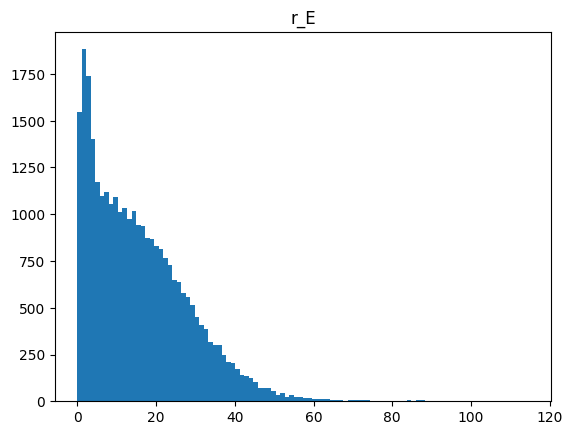

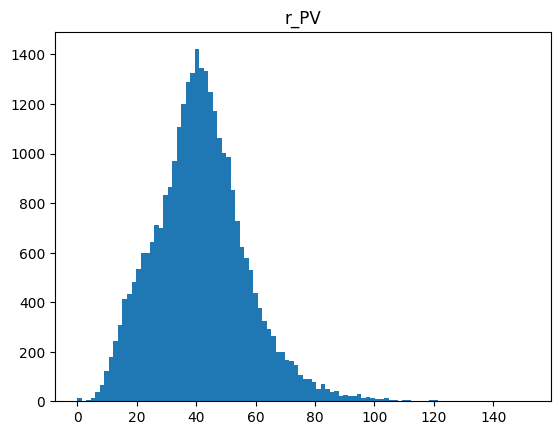

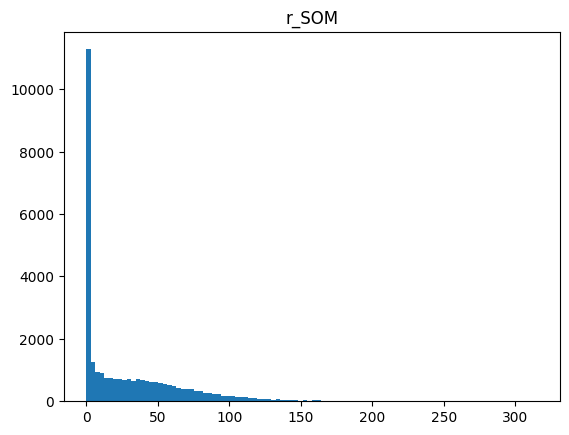

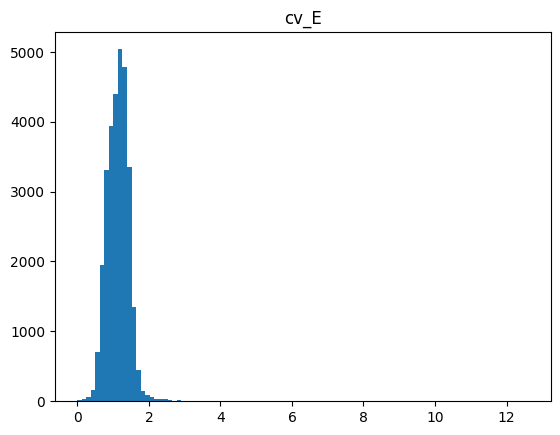

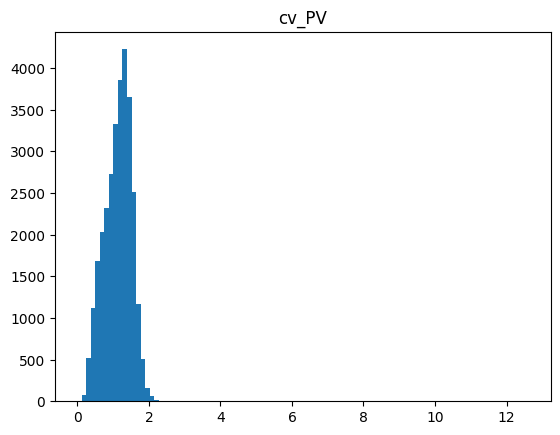

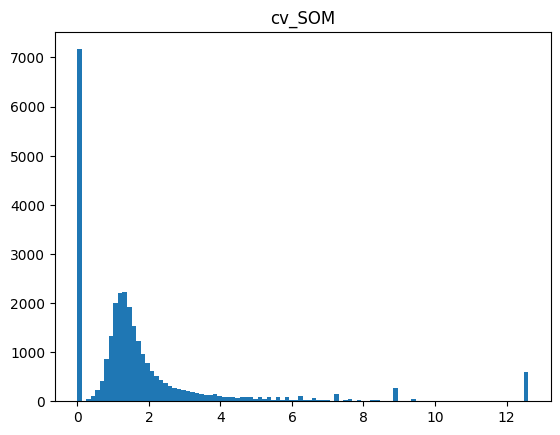

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pylab as plt
with open("LIF_training_data_intelligent.pkl", 'rb') as handle:
        (final_params_to_run, final_outputs) = pickle.load(handle)
labels = ["r_E", "r_PV", "r_SOM", "cv_E", "cv_PV", "cv_SOM"]
for output, label in zip(final_outputs.T, labels):
    plt.hist(output, bins = 100)
    plt.title(label)
    plt.figure()

In [29]:
print("Average Training Data Parameters")
labels = ["S_EE", "S_EPV", "S_ESOM", "S_PVE", "S_PVPV", "S_PVSOM", "S_SOME", "S_SOMPV", "S_SOMSOM", "lam_E", "lam_I", "lam_lat", "df_EE", "df_EPV", "df_ESOM",
          "df_PVE", "df_PVPV", "df_PVSOM", "df_SOME", "df_SOMPV", "df_SOMSOM", "tau_dE", "tau_dPV", 
          "tau_dSOM"]
for i, (label, param) in enumerate(zip(labels, final_params_to_run.mean(axis = 0))):
    print(f"{i}. {label}: {param}")

Average Training Data Parameters
0. S_EE: 0.020676971507270943
1. S_EPV: 0.04727847630142267
2. S_ESOM: 0.024441933292703052
3. S_PVE: 0.013510746507808345
4. S_PVPV: 0.033494983944064555
5. S_PVSOM: 0.0074938613203896
6. S_SOME: 0.019187099665676825
7. S_SOMPV: 0.029110470863134966
8. S_SOMSOM: 0.002040349739480229
9. lam_E: 1.1001547710875126
10. lam_I: 0.8258619872099688
11. lam_lat: 0.5519385953250687
12. df_EE: 0.40273859243060545
13. df_EPV: 0.6127019936005084
14. df_ESOM: -0.49901937442513045
15. df_PVE: 0.6616119740070557
16. df_PVPV: 0.28667814626414606
17. df_PVSOM: -0.4309982589752219
18. df_SOME: -0.17158167811484812
19. df_SOMPV: 0.38942262343144907
20. df_SOMSOM: 0.37307108222440527
21. tau_dE: 0.054828852593373695
22. tau_dPV: 0.009500780341695264
23. tau_dSOM: 0.07731324211403562
